## Importações e dependências

In [1]:
import os
import glob
import cv2
import numpy as np
import hashlib
import matplotlib.pyplot as plt

from keras.preprocessing.image import ImageDataGenerator
from imblearn.over_sampling import RandomOverSampler
from keras.preprocessing.image import ImageDataGenerator
from collections import Counter

print("Importações e dependencias feitas com sucesso")

Importações e dependencias feitas com sucesso


## Importar Imagens 
Importação de imagens do conjunto teste e treino para efetuar o seu processamento. Ao importar a imagem é tambem guardado o nome a ela associado e é criada uma hash para posteriormente verificar se existem imagens duplicadas.



In [2]:
#Função para calcular uma hash para cada imagem
def calculate_hash(img):
    return hashlib.sha256(img).hexdigest()

# Função para carregar imagens de uma dada pasta
def load_images_from_folder(folder):
    images = []
    hashes=[]
    path=[]
    #Considera todas as pastas dentro do diretorio em que se encontra
    disease_folder=glob.glob(os.path.join(folder, "*"))
    for files in disease_folder:
        print(f"A carregar imagens... {files}")
        for filename in os.listdir(files):
            try:
                img = cv2.imread(os.path.join(files, filename),cv2.IMREAD_UNCHANGED)
                if img is not None:
                    images.append(img)
                    path.append(filename)
                    hash_imagem=calculate_hash(img)
                    hashes.append(hash_imagem)
                else:
                    print(f"Não foi possível carregar a imagem: {filename}")
            except Exception as e:
                    print(f"Erro ao carregar a imagem {filename}: {str(e)}")           
    return images, hashes, path

# Diretório onde estão as imagens
train_folder = '/Users/hugopereira/DatasetMEIA/train'
test_folder = '/Users/hugopereira/DatasetMEIA/test'
#train_folder = 'C:/Dev/DatasetMEIA/train'
#test_folder = 'C:/Dev/DatasetMEIA/test'
if os.path.exists(train_folder):
    print("O caminho existe e está acessível.")
else:
    print("O caminho não existe ou não está acessível.")

# Carregar imagens de treino e teste
train_images, train_hashes, train_names = load_images_from_folder(train_folder)
test_images, test_hashes, test_names = load_images_from_folder(test_folder)

# Verificar se as imagens foram carregadas corretamente
print(f"Número de imagens de treino carregadas: {len(train_images)}")
print(f"Número de imagens de teste carregadas: {len(test_images)}")

O caminho existe e está acessível.
A carregar imagens... /Users/hugopereira/DatasetMEIA/train/Urticaria Hives
A carregar imagens... /Users/hugopereira/DatasetMEIA/train/Psoriasis pictures Lichen Planus and related diseases
A carregar imagens... /Users/hugopereira/DatasetMEIA/train/Lupus and other Connective Tissue diseases
A carregar imagens... /Users/hugopereira/DatasetMEIA/train/Atopic Dermatitis Photos
A carregar imagens... /Users/hugopereira/DatasetMEIA/train/Melanoma Skin Cancer Nevi and Moles
A carregar imagens... /Users/hugopereira/DatasetMEIA/test/Urticaria Hives
A carregar imagens... /Users/hugopereira/DatasetMEIA/test/Psoriasis pictures Lichen Planus and related diseases
A carregar imagens... /Users/hugopereira/DatasetMEIA/test/Lupus and other Connective Tissue diseases
A carregar imagens... /Users/hugopereira/DatasetMEIA/test/Atopic Dermatitis Photos
A carregar imagens... /Users/hugopereira/DatasetMEIA/test/Melanoma Skin Cancer Nevi and Moles
Número de imagens de treino carr

## Visualização das Imagens

In [3]:
#Função para ver as imagens lado a lado
def see_array_plt(images, images_title=None):
    num_images = len(images)
    if images_title is None:
        images_title = [f"Image {i+1}" for i in range(num_images)]
        
    num_rows = (num_images - 1) // 3 + 1
    plt.figure(figsize=(20, 6 * num_rows))
    for num in range(num_images):
        plt.subplot(num_rows, 3, num + 1)
        plt.axis(False)
        plt.title(f"{images_title[num]}.")
        plt.imshow(images[num]);

Visualização de algumas imagens de treino


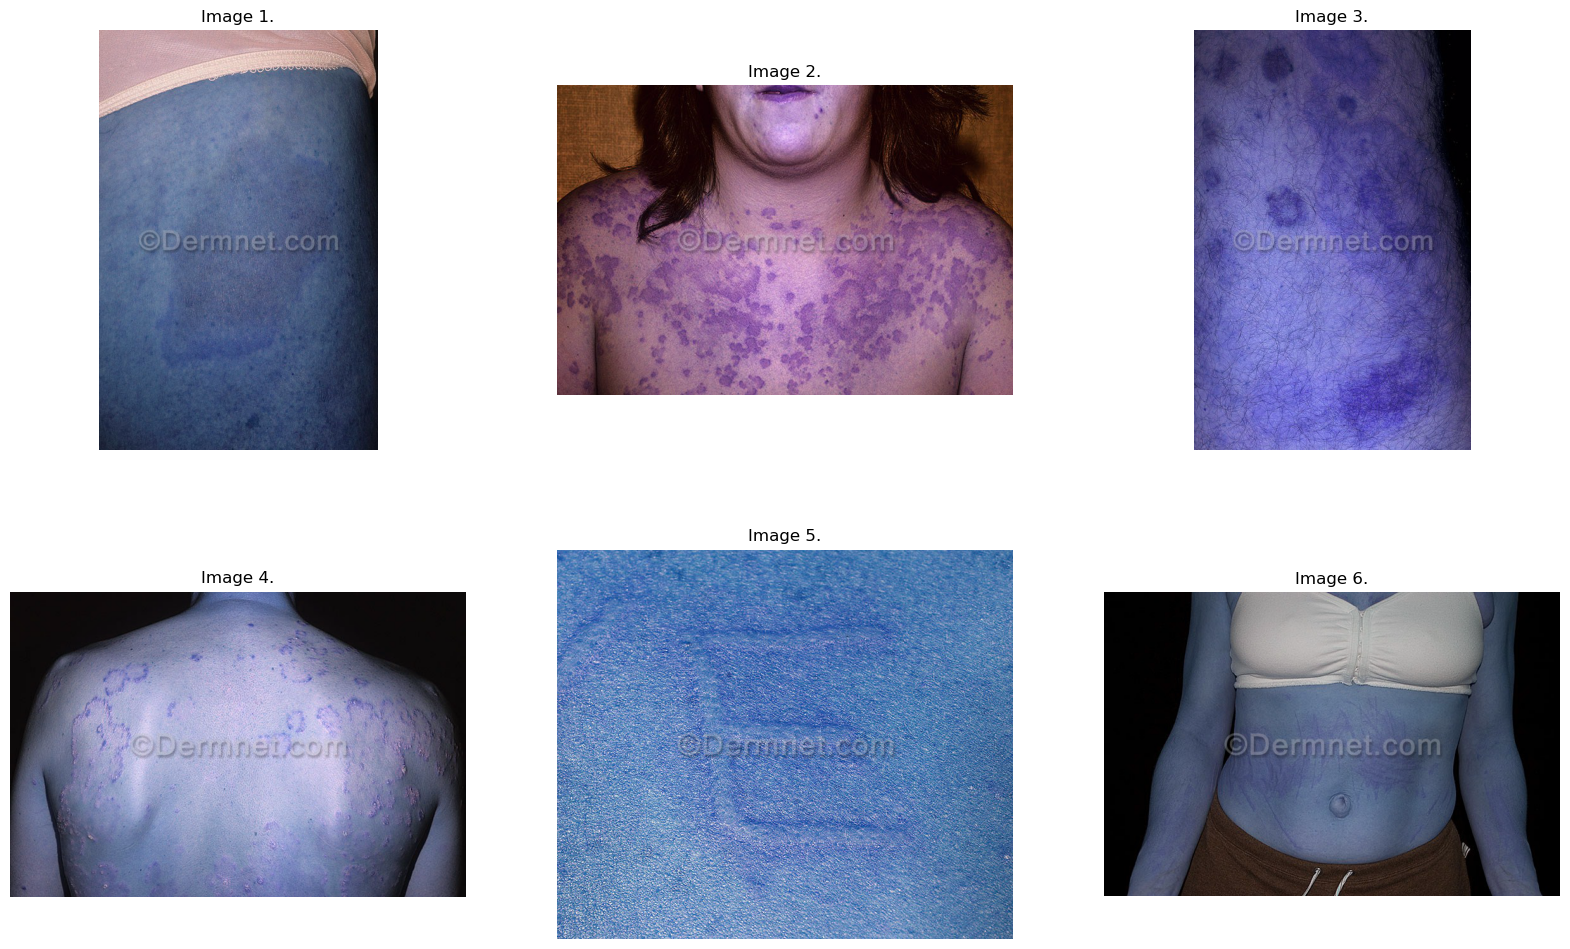

-------------------------------------------------
Visualização de algumas imagens de teste


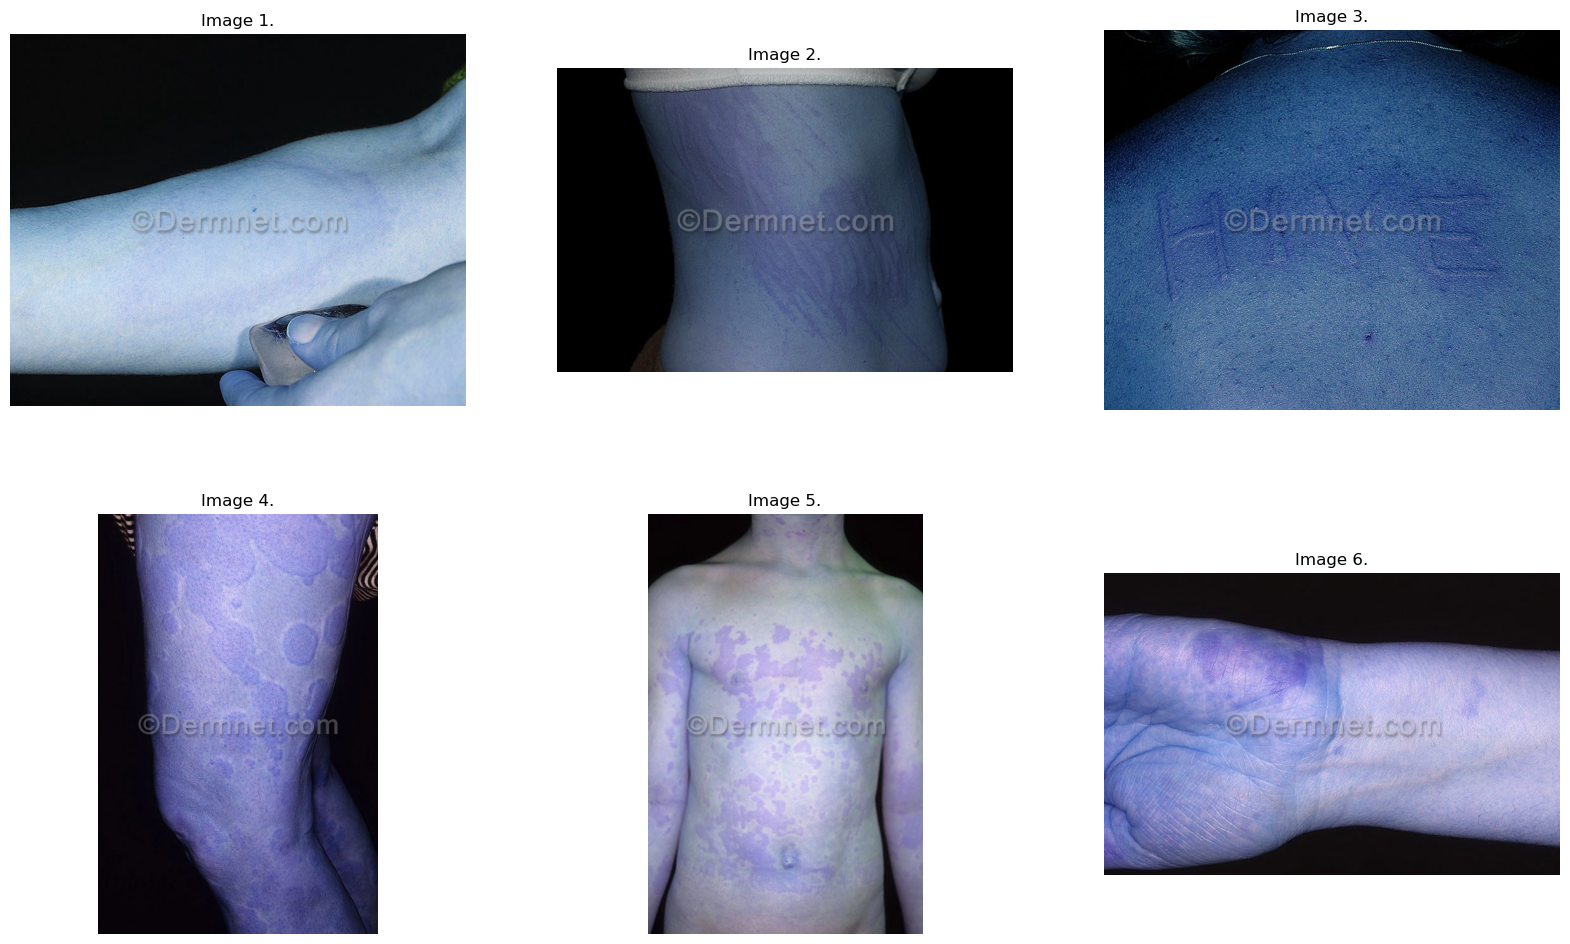

In [4]:
max_images = 6  # Define o número máximo de imagens a serem mostradas
print("Visualização de algumas imagens de treino")
see_array_plt(train_images[:max_images])
plt.show()  # Garante que as imagens de treino sejam exibidas antes do próximo print
print("-------------------------------------------------")
print("Visualização de algumas imagens de teste")
see_array_plt(test_images[:max_images])
plt.show()  # Garante que as imagens de treino sejam exibidas antes do próximo print

# Pré-processamento

## 1.1 Verificação de Imagens Duplicadas

Para ambos os conjuntos(treino e teste) é verificado atravês das hashes previamente criadas se existem hashes duplicadas e consequentemente imagens duplicadas. 
Caso existam, a posição de um elemento do conjunto de duplicação é guardada num array separado para ser posteriormente essa posição ser elimininada do array das imagens, do nome das imagens, e das hashes das imagens. Este processo é efetuado ate o array que guarda os conjuntos de duplicados tenha tamanho 0, para prevenir que elimina imagens que possuam aparecer triplicadas, quadriplicadas, etc.

In [5]:
#Verificar se existe imagens duplicadas
def find_duplicate_hashes(caminhos_imagens, hashes_imagens):
    duplicate=[]
    check_hashes=set()
    for i, hash_atual in enumerate(hashes_imagens):
        if hash_atual not in check_hashes:
            check_hashes.add(hash_atual)
            for j in range(i + 1, len(hashes_imagens)):
                if hash_atual == hashes_imagens[j]:
                    duplicate.append((caminhos_imagens[i], caminhos_imagens[j]))

    return duplicate

def see_duplicate(duplicate, folder,tam):
    if len(duplicate)>0: 
        print(f"Foram encontradas {len(duplicate)} imagens duplicadas encontradas no conjunto {folder}:")
        print(duplicate)
    else:
        print(f"Não foram encontradas imagens duplicadas no conjunto {folder}  com o tamanho {tam}.")

def delete_duplicate(images,names,hashes,duplicate):
    index_to_remove = []
    for dupla in duplicate:
        img1,img2=dupla
        for index, name_image in enumerate(names):
            if img1==name_image:
                index_to_remove.append(index)
                
    # Remove as imagens duplicadas onde a sua posição se encontra guardada em index_to_remove
    print(f"Vao ser removidas {len(index_to_remove)} instancias ao total de {len(images)} ficando com um tamanho de {len(images)-len(index_to_remove)}")
    for index in sorted(index_to_remove, reverse=True):
        del images[index]
        del names[index]
        del hashes[index]
        
    return images,names,hashes

duplicate_train=find_duplicate_hashes(train_names, train_hashes)
duplicate_test=find_duplicate_hashes(test_names, test_hashes)
while (len(duplicate_train) > 0) or (len(duplicate_test) > 0 ):
    see_duplicate(duplicate_train,"treino",len(train_names))
    train_images_del,train_names_del,train_hashes_del=delete_duplicate(train_images,train_names,train_hashes,duplicate_train)
    print("-------------------------------------")
    see_duplicate(duplicate_test, "test", len(test_names))
    test_images_del,test_names_del,test_hashes_del=delete_duplicate(test_images,test_names,test_hashes,duplicate_test)
    #print("-------------------------------------")
    duplicate_train=find_duplicate_hashes(train_names, train_hashes)
    duplicate_test=find_duplicate_hashes(test_names, test_hashes)


print("-------------------------------------")
train_images=train_images_del
train_names=train_names_del
train_hashes=train_hashes_del
print(f"Nova tamanho do array de treino: {len(train_images)} e do array dos nomes do treino:  {len(train_names)} e das hashes: {len(train_hashes)}")
test_images=test_images_del
test_names=test_names_del
test_hashes=test_hashes_del
print(f"Novo tamanho do array de teste: {len(test_images)} e do array dos nomes de teste:  {len(test_names)} e das hashes: {len(test_hashes)}")

Foram encontradas 51 imagens duplicadas encontradas no conjunto treino:
[('dermagraphism-30.jpg', 'dermagraphism-40.jpg'), ('dermagraphism-30.jpg', 'dermagraphism-41.jpg'), ('pressure-urticaria-7.jpg', 'pressure-urticaria-2.jpg'), ('pressure-urticaria-7.jpg', 'pressure-urticaria-1.jpg'), ('Lichen-Planus-Hypertrophic-1.jpg', 'Lichen-Planus-Hypertrophic-14.jpg'), ('psoriasis-scalp-68.jpg', 'seborrheic-dermatitis-127.jpg'), ('pityriasis-rosea-112.jpg', 'pityriasis-rosea-137.jpg'), ('Psoriasis-Guttate-25.jpg', 'Psoriasis-Guttate-41.jpg'), ('Lichen-Planus-Penis-4.jpg', 'Lichen-Sclerosus-Penis-1.jpg'), ('Psoriasis-Guttate-26.jpg', 'Psoriasis-Guttate-42.jpg'), ('08SebDermq.jpg', 'seborrheic-dermatitis-8.jpg'), ('08LSASkin.jpg', 'Lichen-Sclerosus-Skin-42.jpg'), ('psoriasis-palms-soles-126.jpg', 'psoriasis-palms-soles-138.jpg'), ('psoriasis-erythrodermic-34.jpg', 'Psoriasis-Hand-21.jpg'), ('psoriasis-erythrodermic-30.jpg', 'psoriasis-erythrodermic-29.jpg'), ('psoriasis-erythrodermic-30.jpg', 'P

## 1.2 Redimensionar Imagens
Para ambos os conjuntos(treino e teste) o tamanho das imagens é ajustado, cortando a imagem caso esta seja maior que o tamanho pretendido(224x224) ou então aumentada atraves de uma borda.

In [6]:
# Redimensionar imagens
def resize_images(images, new_size):
    resized_images = []
    for img in images:
        resized_img = cv2.resize(img, new_size)
        resized_images.append(resized_img)
    return resized_images

# Tamanho desejado para as imagens (250x250)
new_size = (250, 250)

# Redimensionar imagens de treino e teste
train_images_resized = resize_images(train_images, new_size)
test_images_resized = resize_images(test_images, new_size)

# Verificar se as imagens foram redimensionadas corretamente
print(f"Número de imagens de treino redimensionadas: {len(train_images_resized)}")
print(f"Número de imagens de teste redimensionadas: {len(test_images_resized)}")

Número de imagens de treino redimensionadas: 2933
Número de imagens de teste redimensionadas: 746


## 1.5 Análise de Filtros de Cor

In [13]:
#Função para visualizar uma imagem a partir do cv2
def see_cv2(title, img, stop=False):
    if not title: cv2.imshow(img) 
    else: cv2.imshow(title,img)
    if stop: 
        cv2.waitKey(0) 
        cv2.destroyAllWindows()
        
#Função para visualizar uma imagem a partir do plot
def see_plt(title, img):
    if title: plt.title(title)
    plt.imshow(img)  
    plt.show()

#Cria a variavel original para testar e analisar diferentes tipos de manipulações a mesma imagem
#original=train_images_resized[0]
original=train_images_resized[0]

print("Funções e imagem original criadas com sucesso.")

Funções e imagem original criadas com sucesso.


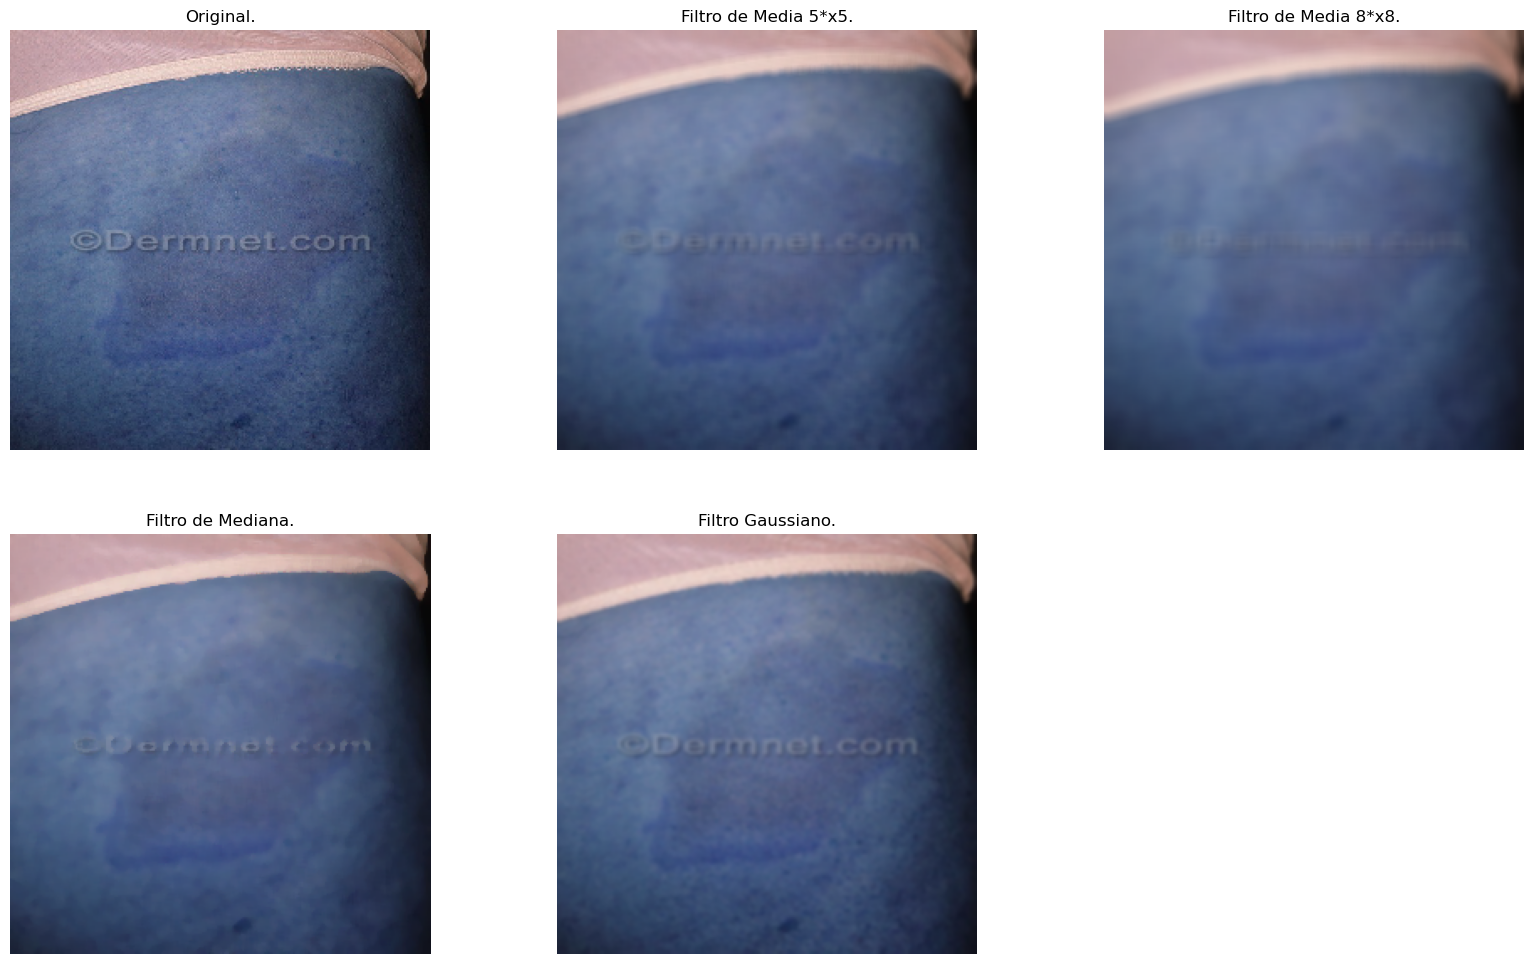

In [14]:
# Filtros de cor
def see_filters(img):
    filter_array=[]
    filter_legend=[]

    
    title="Original"
    filter_array.append(img)
    filter_legend.append(title)
    #see_cv2(title,img)
    #see_plt(title,img)
    
    # Filtro de Média 5*5
    media5 = cv2.blur(img, (5, 5))  # Aplica um filtro de média 5x5
    title="Filtro de Media 5*x5"
    filter_array.append(media5)
    filter_legend.append(title)
    #see_cv2(title,media)
    #see_plt(title,media)

    # Filtro de Média 8*8
    media8 = cv2.blur(img, (8, 8))  # Aplica um filtro de média 8x8
    title="Filtro de Media 8*x8"
    filter_array.append(media8)
    filter_legend.append(title)
    #see_cv2(title,media)
    #see_plt(title,media)
    
    
    #Filtro de Mediana
    mediana = cv2.medianBlur(img, 5)  # Aplica um filtro de mediana 5x5
    title="Filtro de Mediana"
    filter_array.append(mediana)
    filter_legend.append(title)
    #see_cv2(title,mediana)
    #see_plt(title,mediana)
    
    # Filtro Gaussiano
    gaussiano = cv2.GaussianBlur(img, (5, 5), 0)  # Aplica um filtro Gaussiano 5x5
    title="Filtro Gaussiano"
    filter_array.append(gaussiano)
    filter_legend.append(title)
    #see_cv2(title,gaussiano,True)
    #see_plt(title,gaussiano)

    return filter_array,filter_legend, media8


filter_array,filter_legend, media8=see_filters(original)

see_array_plt(filter_array,filter_legend)

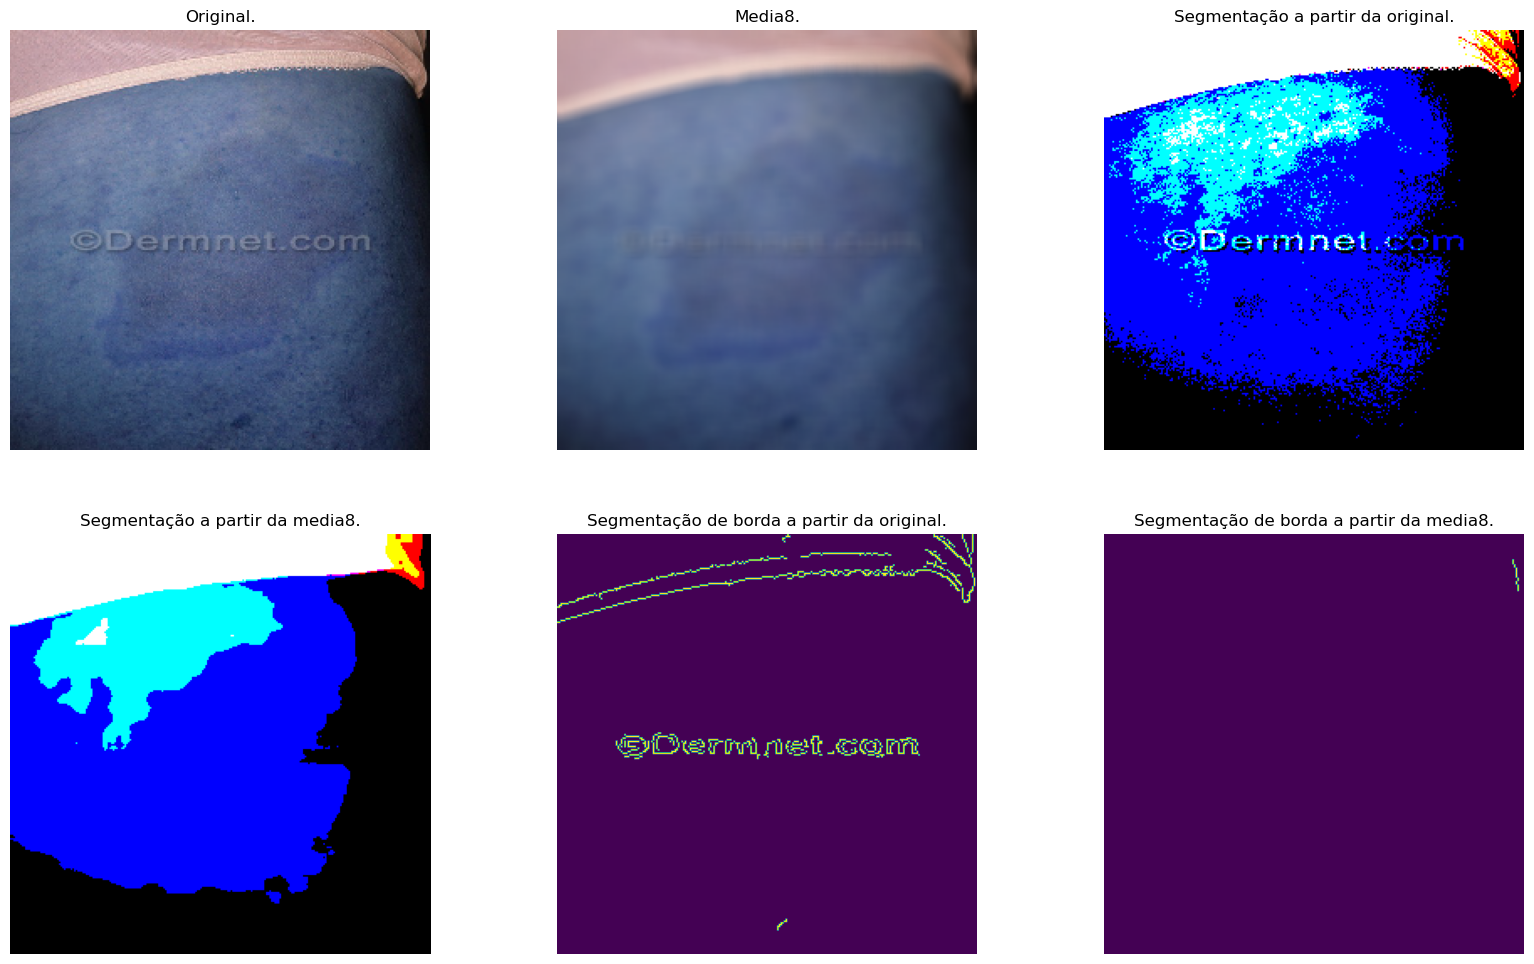

In [9]:
#Segmentation Limiar

segmentation_array=[]
segmentation_array_legend=[]

segmentation_array.append(original)
segmentation_array_legend.append("Original")

segmentation_array.append(media8)
segmentation_array_legend.append("Media8")

# Aplicar o método de limiarização
_, thresholded_image_original = cv2.threshold(original, 120, 255, cv2.THRESH_BINARY)
_, thresholded_image_media8 = cv2.threshold(media8, 120, 255, cv2.THRESH_BINARY)

segmentation_array.append(thresholded_image_original)
segmentation_array_legend.append("Segmentação a partir da original")

segmentation_array.append(thresholded_image_media8)
segmentation_array_legend.append("Segmentação a partir da media8")

edge_original = cv2.Canny(original, 100, 200)
segmentation_array.append(edge_original)
segmentation_array_legend.append("Segmentação de borda a partir da original")

edge_media8 = cv2.Canny(media8, 100, 200)
segmentation_array.append(edge_media8)
segmentation_array_legend.append("Segmentação de borda a partir da media8")

see_array_plt(segmentation_array, segmentation_array_legend)


In [ ]:
def foreground_detection(image):
    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Apply Gaussian blur to reduce noise
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    
    # Set a threshold to create a binary mask
    _, mask = cv2.threshold(blurred, 165, 255, cv2.THRESH_BINARY)
    
    # Invert the mask
    mask = cv2.bitwise_not(mask)
    
    # Find contours in the mask
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Draw the contours on the original image
    result = image.copy()
    cv2.drawContours(result, contours, -1, (0, 255, 0), 2)
    
    return result

def teste(image):
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Define the range for skin color in HSV
    lower_skin = np.array([0, 20, 30], dtype=np.uint8)
    upper_skin = np.array([50, 100, 255], dtype=np.uint8)

    # Create a binary mask for skin color
    skin_mask = cv2.inRange(hsv_image, lower_skin, upper_skin)

    return skin_mask

# Perform foreground/background detection
output_image = teste(train_images[0])
output_image2=foreground_detection(train_images[0])

# Display the result
cv2.imshow('Result', output_image)
cv2.destroyAllWindows()
cv2.imshow('Result 2', output_image2)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [ ]:
def pre_processamento(image):
    image_steps=[]
    images_steps_category=[]
    
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    image_steps.append(gray_image)
    images_steps_category.append("Cinzenta")
    
    # Normalizar iluminação
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    normalized = clahe.apply(gray_image)
    
    image_steps.append(normalized)
    images_steps_category.append("Normalizar Iluminiação")
    
    # Suavização da imagem
    blurred = cv2.GaussianBlur(normalized, (5, 5), 0)

    image_steps.append(blurred)
    images_steps_category.append("Gaussian")

    #Filtro da Media
    media = cv2.blur(blurred, (5, 5))  # Aplica um filtro de média 5x5
    media2 = cv2.blur(blurred, (8, 8))  # Aplica um filtro de média 5x5

    image_steps.append(media)
    images_steps_category.append("Media 5x5")

    image_steps.append(media2)
    images_steps_category.append("Media 8x8")
    
    # Detecção de bordas
    edges = cv2.Canny(blurred, 50, 150)

    # Definir faixa para cor da pele em HSV
    lower_skin = np.array([0, 30, 60], dtype=np.uint8)
    upper_skin = np.array([20, 150, 255], dtype=np.uint8)

    # Criar máscara binária para a cor da pele
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    skin_mask = cv2.inRange(hsv_image, lower_skin, upper_skin)

    # Aplicar a máscara da pele à detecção de bordas
    skin_edges = cv2.bitwise_and(edges, edges, mask=skin_mask)

    return skin_edges, image_steps, images_steps_category

_,image_steps,image_steps_category=pre_processamento(train_images[0])
see_array_plt(image_steps,image_steps_category)

## 1.3 Conversão para arrays numpy

Ambos os conjuntos(treino e teste) são convertidos em arrays numpy

In [ ]:
# Converter listas de imagens para arrays numpy
#train_images_array = np.array(train_images_resized)
#test_images_array = np.array(test_images_resized)

# Verificar se as imagens foram convertidas corretamente para arrays numpy
#print(f"Número de imagens de treino arrays numpy: {len(train_images_array)}")
#print(f"Número de imagens de teste arrays numpy: {len(test_images_array)}")

In [ ]:
#from keras.utils import to_categorical

# One-hot
#class_to_int = {
    #'Atopic Dermatitis Photos': 1,
    #'Melanoma Skin Cancer Nevi and Moles': 2,
    #'Psoriasis pictures Lichen Planus and related diseases': 3,
    #'Urticaria Hives': 4
#}

# Converta suas labels para números inteiros usando o mapeamento
#train_labels_int = [class_to_int[label] for label in train_labels]
#test_labels_int = [class_to_int[label] for label in test_labels]

# Transforme os números inteiros em vetores one-hot
#train_labels_one_hot = to_categorical(train_labels_int, num_classes=5)
#test_labels_one_hot = to_categorical(test_labels_int, num_classes=5)

In [ ]:
#print("Formato das labels de treinamento após one-hot encoding:", train_labels_one_hot.shape)

In [ ]:
#print("Labels de treinamento após one-hot encoding:", train_labels_one_hot)

## 1.4 Análise dos dados atuais

Para ambos os conjuntos(treino e teste) é feita uma analise dos dados atuais atravês do atributo "shape" atribuido aos arrays numpy. O output do atributo shape é (numero de imagens, pixel de altura, pixel de largura, canais de cor)

In [9]:
#print(f"Shape do array de imagens de treino: {train_images_array.shape}")
#print(f"Shape do array de imagens de teste: {test_images_array.shape}")

NameError: name 'train_images_array' is not defined

## 1.6 Normalização

Transformação de cada instancia para um intervalo especifico: [0,1]. 

In [23]:
# Normalização
#def normalize_images(images):
    #normalized_images = []
    #for img in images:
        #normalized_img = img / 255.0  # Normalizar os valores dos pixels para o intervalo [0, 1]
        #normalized_images.append(normalized_img)
    #return np.array(normalized_images)

# Normalizar imagens de treinamento e teste
#train_images_normalized = normalize_images(train_images_resized)
#print(f"Imagens do treino normalizadas concluídas...")

#test_images_normalized = normalize_images(test_images_resized)
#print(f"Imagens do teste normalizadas concluídas...")


Imagens do treino normalizadas concluídas...
Imagens do teste normalizadas concluídas...


## 1.7 Augmentation
Criação de novos exemplos de treino, nomeadamente imagens atravês de simples transformações: 
- `rotation_range`: Define o intervalo de ângulos nos quais as imagens podem ser rotacionadas aleatoriamente.
- `width_shift_range`: Especifica a faixa (em fração da largura total da imagem) na qual a imagem pode ser deslocada horizontalmente.
- `height_shift_range`: Especifica a faixa (em fração da altura total da imagem) na qual a imagem pode ser deslocada verticalmente.
- `zoom_range`: Define a faixa para aplicar zoom aleatório nas imagens.
- `horizontal_flip`: Booleano que indica se as imagens devem ser viradas horizontalmente aleatoriamente.
- `brightness_range`: Intervalo que define a faixa de ajuste de brilho para as imagens.


In [10]:
#Augmentation
# Criar um gerador de imagens com técnicas de aumento de dados
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2]
)

# Redimensionar imagens para o formato esperado pelo ImageDataGenerator
#train_images_augmented = train_images_normalized.reshape(-1, new_size[0], new_size[1], 3)

# Ajustar o gerador às imagens de treinamento
#datagen.fit(train_images_augmented)

## 1.8 Normalização e Balanceamento dos dados

Para balancear as classes existentes implementamos o Random Over Sampler, este aumenta artificialmente o número de exemplos nas classes minoritárias.


In [7]:
import os
import numpy as np
from imblearn.over_sampling import RandomOverSampler

def normalize_images(images):
    normalized_images = []
    for img in images:
        normalized_img = img / 255.0  # Normalizar os valores dos pixels para o intervalo [0, 1]
        normalized_images.append(normalized_img)
    return np.array(normalized_images)

def assign_labels_from_folders(images_folder):
    labels = []
    for folder_name in os.listdir(images_folder):
        folder_path = os.path.join(images_folder, folder_name)
        if os.path.isdir(folder_path):
            for image_name in os.listdir(folder_path):
                labels.append(folder_name)
    return labels

# Normalizar imagens de treinamento e teste
train_images_normalized = normalize_images(train_images_resized)
print(f"Imagens do treino normalizadas concluídas...")

test_images_normalized = normalize_images(test_images_resized)
print(f"Imagens do teste normalizadas concluídas...")

# Atribuir rótulos às imagens de treinamento e teste com base nas pastas
train_labels = assign_labels_from_folders('/Users/hugopereira/DatasetMEIA/train')
test_labels = assign_labels_from_folders('/Users/hugopereira/DatasetMEIA/test')

# Ajustar os rótulos para corresponder ao número de imagens normalizadas
train_labels = train_labels[:len(train_images_normalized)]

# Verificar se o número de rótulos corresponde ao número de imagens normalizadas
if len(set(train_labels)) != 5:
    print("O número de rótulos não corresponde ao número esperado de classes.")

# Realizar oversampling apenas nas classes minoritárias após a normalização
ros = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(train_images_normalized.reshape(train_images_normalized.shape[0], -1), train_labels)

# Verificação do balanceamento após oversampling
unique_resampled, counts_resampled = np.unique(y_train_resampled, return_counts=True)
class_counts_resampled = dict(zip(unique_resampled, counts_resampled))

print("Contagem de amostras por classe após oversampling e normalização:")
print(class_counts_resampled)

Imagens do treino normalizadas concluídas...
Imagens do teste normalizadas concluídas...
Contagem de amostras por classe após oversampling e normalização:
{'Atopic Dermatitis Photos': 1405, 'Lupus and other Connective Tissue diseases': 1405, 'Melanoma Skin Cancer Nevi and Moles': 1405, 'Psoriasis pictures Lichen Planus and related diseases': 1405, 'Urticaria Hives': 1405}


# Guardar os novos dados
Após o pre-processamento estar concluido guardar a nova instancia dos dados para posteriormente utiliza-los para treinar diferentes modelos 

In [9]:
# Guardar o data-set pre-processado

# Criar a pasta se ela não existir
#folder_train = 'DataProcessed/train'
#folder_test = 'DataProcessed/test'
#if not os.path.exists(folder_train):
    #os.makedirs(folder_train)

#if not os.path.exists(folder_test):
    #os.makedirs(folder_test)

# Guardar imagens pré-processadas e rótulos em arquivos NumPy
#print("A guardar.....")

#print("Formato do array Train:", train_images_balanced.shape)
#np.save(os.path.join(folder_train, 'train_images.npy'), train_images_balanced)

# Usar len() para obter o comprimento da lista train_labels_balanced
#print("Número de rótulos de treinamento:", len(train_labels_balanced))
#np.save(os.path.join(folder_train, 'train_labels.npy'), train_labels_balanced)

#print("Formato do array Test:", test_images_balanced.shape)
#np.save(os.path.join(folder_test, 'test_images.npy'), test_images_balanced)

# Usar len() para obter o comprimento da lista test_labels_balanced
#print("Número de rótulos de teste:", len(test_labels_balanced))
#np.save(os.path.join(folder_test, 'test_labels.npy'), test_labels_balanced)
#print("Guardado com sucesso.")

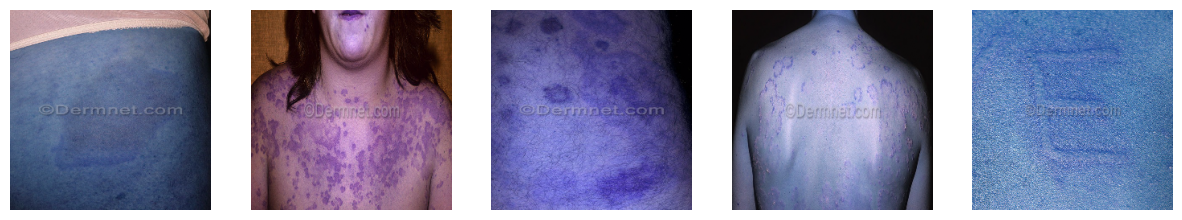

In [13]:
import matplotlib.pyplot as plt

# Visualizar algumas imagens de treino após o pré-processamento
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i, ax in enumerate(axes):
    ax.imshow(X_train_resampled[i].reshape(250, 250, 3))  # Se a imagem estiver em escala de cinza, pode ser necessário remover o reshape
    ax.axis('off')
plt.show()

In [21]:
import os

# Função para salvar as imagens corretamente em pastas separadas por labels
def save_images_with_labels(images, labels, folder_path):
    unique_labels = set(labels)
    for label in unique_labels:
        label_folder = os.path.join(folder_path, label)
        os.makedirs(label_folder, exist_ok=True)  # Cria a pasta da label se ainda não existir
        label_indices = [i for i, l in enumerate(labels) if l == label]
        label_images = [images[i] for i in label_indices]  # Corrigindo a obtenção das imagens
        print(f"Label: {label}, Número de imagens: {len(label_images)}")
        for i, img in enumerate(label_images):
            img_uint8 = (img * 255).astype(np.uint8)
            cv2.imwrite(os.path.join(label_folder, f"image_{i}.jpg"), img_uint8)

# Caminhos das pastas de treino e teste
train_folder_preprocessed = '/Users/hugopereira/Github/Left4Health_3rdProject/ClassificationOfSkinDiseases/preprocessed/train'
test_folder_preprocessed = '/Users/hugopereira/Github/Left4Health_3rdProject/ClassificationOfSkinDiseases/preprocessed/test'

# Remover duplicatas nos rótulos de teste
test_images_unique = []
test_labels_unique = []
for i, label in enumerate(test_labels):
    if label not in test_labels_unique:
        test_labels_unique.append(label)
        test_images_unique.append(test_images_normalized[i])

# Salvar imagens de treino
save_images_with_labels(X_train_resampled.reshape(-1, 250, 250, 3), train_labels, train_folder_preprocessed)

# Salvar imagens de teste
save_images_with_labels(test_images_unique, test_labels_unique, test_folder_preprocessed)

Label: Atopic Dermatitis Photos, Número de imagens: 489
Label: Lupus and other Connective Tissue diseases, Número de imagens: 420
Label: Psoriasis pictures Lichen Planus and related diseases, Número de imagens: 1405
Label: Melanoma Skin Cancer Nevi and Moles, Número de imagens: 407
Label: Urticaria Hives, Número de imagens: 212
Label: Atopic Dermatitis Photos, Número de imagens: 1
Label: Lupus and other Connective Tissue diseases, Número de imagens: 1
Label: Psoriasis pictures Lichen Planus and related diseases, Número de imagens: 1
Label: Melanoma Skin Cancer Nevi and Moles, Número de imagens: 1
Label: Urticaria Hives, Número de imagens: 1
